**One-Bit Compressed Sensing for Image Compression**

In [1]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.fftpack import dct
import numpy as np
import os
import zipfile
import time

**Define data pre-processing functions**

In [2]:
# Import the mnist dataset
# ------------------------------------------------------------------
# Replace the old `import_mnist_data` function with this version
# ------------------------------------------------------------------
def import_mnist_data(num_img=None, as_flat=True):
    """
    Load MNIST from torchvision (or Keras) and return it as a NumPy array.

    Parameters
    ----------
    num_img : int or None
        Number of images to return.  If None, return the full dataset.
    as_flat : bool
        If True, each 28×28 image is flattened to a 784-element vector.

    Returns
    -------
    np.ndarray  shape (num_img, 784)  or  (num_img, 28, 28)
    """
    try:
        from torchvision import datasets, transforms
        import torch
        transform = transforms.Compose([transforms.ToTensor()])
        mnist = datasets.MNIST(root="./mnist_data/",
                               train=True, download=True, transform=transform)
        imgs = mnist.data.numpy().astype("float32")   # shape (60000, 28, 28)
    except ImportError:
        # Fallback to TensorFlow/Keras if torchvision is not available
        from tensorflow.keras.datasets import mnist as keras_mnist
        (imgs, _), _ = keras_mnist.load_data()
        imgs = imgs.astype("float32")

    if num_img is not None:
        imgs = imgs[:num_img]

    if as_flat:
        imgs = imgs.reshape(imgs.shape[0], -1)  # (N, 784)
    return imgs


# Returns images at the specified indices
def get_images(data, index, num_img=1):
    # Get the image at the specified index
    image = data[index:index+num_img,:]
    # Reshape the image to 28x28
    image = image.reshape(num_img, -1)
    return image

# Sparsify the data by setting all values below a threshold to 0
def sparsify_data(data, threshold):
    sparse_data = np.copy(data)
    for i in range(sparse_data.shape[0]):
        for j in range(sparse_data.shape[1]):
            if sparse_data[i,j] < threshold:
                sparse_data[i,j] = 0

    return sparse_data

# Generates a random measurement matrix with normalized columns
def make_meas_matrix(rows, cols):
    # Generate a matrix of numbers from the standard normal distribution
    meas_matrix = np.random.randn(rows, cols)
    # Normalize the columns of the matrix
    for i in range(cols):
        meas_matrix[:,i] = meas_matrix[:,i] / np.linalg.norm(meas_matrix[:,i])

    return meas_matrix

# Generate measurements from the data using the measurement matrix
def get_measurements(data, meas_matrix):
    return np.sign(meas_matrix @ data.T)

def plot_algos(data, titles, width=14):
    num_images = len(data)
    fig, axs = plt.subplots(1, num_images)
    fig.set_figwidth(width)
    for i in range(0,num_images):
        axs[i].imshow(data[i].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titles[i],fontsize=18)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


def plot_meas_matrix(meas_matrix):
    plt.imshow(meas_matrix, cmap='rainbow', vmin=-1, vmax=1)
    plt.title("Measurement Matrix")
    plt.show()

**Testing out data pre-processing functions**

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.13MB/s]


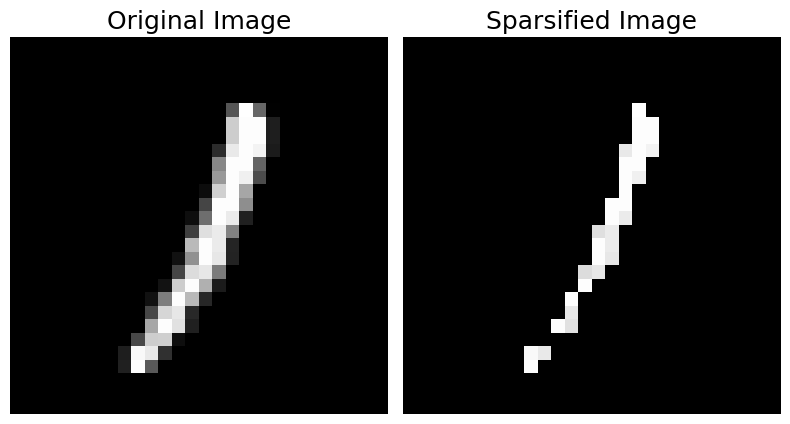

In [3]:
data = import_mnist_data(100)           # ← now works without ZIP
sparse_data = sparsify_data(data, 220)
...

img_idx = 99
img = get_images(data, img_idx)
sparse_img = get_images(sparse_data, img_idx)
plot_algos([img, sparse_img], ["Original Image", "Sparsified Image"], 8)

meas_matrix = make_meas_matrix(200,784)
measurement = get_measurements(sparse_data, meas_matrix)

**Helper Functions**
for calculating metrics, hard and soft thresholding

In [4]:
# Used in hard thresholding
def get_k_support(v, k):
    w = np.copy(v)
    support = np.empty(0, dtype=int)
    for i in range(0, k):
        max_index = np.argmax(abs(w))
        support = np.append(support, max_index)
        w[max_index] = 0
    return support


def calculate_normalized_mse(original_data, est_data):
    original_data = original_data.reshape((-1, 1))
    est_data = est_data.reshape((-1, 1))
    return np.sum((original_data - est_data)**2) / np.sum(original_data**2)

def calculate_missed_coefficients(original_data, est_data):
    original_data = original_data.reshape((-1, 1))
    est_data = est_data.reshape((-1, 1))
    missed_coefficients = np.count_nonzero((original_data != 0) & (est_data == 0))
    return missed_coefficients

def calculate_misidentified_coefficients(original_data, est_data):
    original_data = original_data.reshape((-1, 1))
    est_data = est_data.reshape((-1, 1))
    mis_ided_coefficients = np.count_nonzero((original_data == 0) & (est_data != 0))
    return mis_ided_coefficients

def calculate_wrong_coefficients(original_data, est_data):
    return (calculate_missed_coefficients(original_data, est_data) + calculate_misidentified_coefficients(original_data, est_data))

def calculate_cosine_similarity(original_data, est_data):
    return (original_data.T @ est_data) / (np.linalg.norm(original_data) * np.linalg.norm(est_data))


**One-bit compressed sensing reconstruction algorithms**

**BIHT** - Binary Iterative Hard Thresholding

In [5]:
def biht(meas_matrix, measurement, sparsity, threshold, max_iter, known_sparsity):

    # Initialize estimate as all zeros
    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []

    # Calculate step size
    step_size = np.sqrt(2*np.pi) / (2*meas_matrix.shape[0])

    iter = 0
    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    while iter < max_iter and res_norm > threshold:
        # Gradient descent
        partial_f = meas_matrix.T @ (np.sign(measurement) - np.sign(meas_matrix @ estimate))
        estimate = estimate + step_size * partial_f

        # Hard thresholding
        support = get_k_support(estimate, sparsity)
        temp = np.zeros((meas_matrix.shape[1], 1))
        temp[support,:] = estimate[support,:]
        estimate = temp

        # If the new residual is smaller than the last residual, increase the sparsity
        if known_sparsity == False:
            if (np.linalg.norm(measurement - np.sign(meas_matrix @ estimate)) < res_norm):
                sparsity += 1

        # Calculate residual
        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        iter += 1
    return estimate, convergence

**One-bit OMP** - One-bit orthogonal matching pursuit

In [6]:
def one_bit_omp(meas_matrix, measurement, sparsity, max_iter=None, known_sparsity=True):
    m, n = meas_matrix.shape
    if max_iter is None:
        max_iter = sparsity

    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    support = []
    estimate = np.zeros(n)
    convergence = []

    for it in range(max_iter):
        if len(support) >= sparsity:
            break

        correlations = meas_matrix.T @ residual
        correlations[support] = 0.0  # Mask already selected atoms

        i = np.argmax(np.abs(correlations))
        if i in support:
            continue

        support.append(i)

        # Estimate signal
        A_support = meas_matrix[:, support]
        x_support = np.linalg.pinv(A_support) @ measurement
        estimate = np.zeros(n)
        estimate[support] = x_support

        # If the new residual is smaller than the last residual, increase the sparsity
        if known_sparsity == False:
            if (np.linalg.norm(measurement - np.sign(meas_matrix @ estimate)) < res_norm):
                sparsity += 1

        # Compute residual and convergence metric
        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        if np.all(residual == 0):
            break

    return estimate, convergence


**CVX** - L1 norm minimization with convex sign constraint

In [7]:
import cvxpy as cp

def convex_l1_sign(meas_matrix, measurement, max_iters=1000):
    """
        convergence: Dummy list since CVXPY does not provide step-wise info.
    """
    m, n = meas_matrix.shape
    x = cp.Variable(n)

    # Sign consistency constraints: y_i * (A x)_i >= 1
    constraints = [cp.multiply(measurement, meas_matrix @ x) >= 1]
    objective = cp.Minimize(cp.norm1(x))
    problem = cp.Problem(objective, constraints)

    problem.solve(solver=cp.SCS, max_iters=max_iters)

    estimate = x.value
    if estimate is None:
        estimate = np.zeros(n)  # fallback

    convergence = []  # placeholder for plotting consistency
    return estimate, convergence


**Helper functions to tests algorithms and plot results**

In [18]:
# Loop to test algorithms on multiple images
def test_algo(algo, num_images, sparse_data, measurement_dims, step_size=1e-5, lamda=1, sparsity=10, known_sparsity=False, threshold=0, max_iter=1000):

    mses = []
    missed_coeffs = []
    misided_coeffs = []
    cosine_sims = []
    times = []
    n = sparse_data.shape[1]

    for m in measurement_dims:
        mse_dim = []
        missed_coeff_dim = []
        misided_coeff_dim = []
        cosine_sim_dim = []
        time_dim = []

        for idx in range(0,num_images):
            curr_data = sparse_data[idx,:]

            meas_matrix = make_meas_matrix(m,n)
            measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))

            if (known_sparsity == True):
                sparsity = np.count_nonzero(curr_data != 0)

            start = time.time()
            if (algo == "biht"):
                estimate, convergence = biht(meas_matrix, measurement, sparsity, threshold, max_iter, known_sparsity)
            elif (algo=='one_bit_omp'):
                estimate, convergence=one_bit_omp(meas_matrix, measurement.flatten(), sparsity, max_iter, known_sparsity)
            elif(algo=='inbuilt_solver'):
                estimate,convergence=convex_l1_sign(meas_matrix, measurement.flatten(), max_iters=1000)
            end = time.time()

            # Zero-out negative values - these are erroneous
            estimate[estimate < 0] = 0
            # Renormalize
            estimate = estimate * 255/(np.max(estimate))

            missed_coeff_dim.append(calculate_missed_coefficients(curr_data, estimate))
            misided_coeff_dim.append(calculate_misidentified_coefficients(curr_data, estimate))
            mse_dim.append(calculate_normalized_mse(curr_data, estimate))
            cosine_sim_dim.append(calculate_cosine_similarity(curr_data, estimate))
            time_dim.append(end-start)

        mses.append(np.mean(mse_dim))
        missed_coeffs.append(np.mean(missed_coeff_dim))
        misided_coeffs.append(np.mean(misided_coeff_dim))
        cosine_sims.append(np.mean(cosine_sim_dim))
        times.append(np.mean(time_dim))

    return cosine_sims, mses, missed_coeffs, misided_coeffs, curr_data, estimate, convergence, times

# Plots the original image and the estimated images from a given algorithm and measurement dimensions
def gen_algo_plots(algo_name, algo, data, measurement_dims, step_size=1e-5, lamda=1, sparsity=10, known_sparsity=False, threshold=0, max_iter=1000):
    estimates = [data]
    titles = ["Original Image"]
    n = data.shape[1]

    for m in measurement_dims:
        meas_matrix = make_meas_matrix(m,n)
        measurement = np.reshape(get_measurements(data, meas_matrix), (m,1))

        if (known_sparsity == True):
            sparsity = np.count_nonzero(data != 0)

        if (algo == "rfpi"):
            estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
        elif (algo == "biht"):
            estimate, convergence = biht(meas_matrix, measurement, sparsity, threshold, max_iter, known_sparsity)

        # Zero-out negative values - these are erroneous
        estimate[estimate < 0] = 0
        # Renormalize
        estimate = estimate * 255/(np.max(estimate))
        estimates.append(estimate)
        titles.append(f"{algo_name}, m = {m}")

    plot_algos(estimates, titles)

# Gets the sparsity and cosine similarity for plotting
def plot_sparsities(algo, sparse_data, num_images, m, step_size=1e-5, lamda=1, sparsity=10, known_sparsity=False, threshold=0, max_iter=1000):

    n = sparse_data.shape[1]
    meas_matrix = make_meas_matrix(m,n)

    sparsities = []
    cosine_sims = []
    for idx in range(0,num_images):
        curr_data = sparse_data[idx,:]

        measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))

        true_sparsity = np.count_nonzero(curr_data != 0)
        if (known_sparsity == True):
            sparsity = true_sparsity

        if (algo == "rfpi"):
            estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
        elif (algo == "biht"):
            estimate, convergence = biht(meas_matrix, measurement, sparsity, threshold, max_iter, known_sparsity)

        # Zero-out negative values - these are erroneous
        estimate[estimate < 0] = 0
        # Renormalize
        estimate = estimate * 255/(np.max(estimate))

        cosine_sims.append(calculate_cosine_similarity(curr_data, estimate))
        sparsities.append(true_sparsity/n)

    return cosine_sims, sparsities

# Plots the cosine similarity, mean squared error, and missed/misidentified coefficients
def plot_metrics(algo_name, axs, meas_matrix_dims, cosine_sim, mses, ):
    mses_db = [10*np.log10(x) for x in mses]
    axs[0][0].plot(meas_matrix_dims, cosine_sim, label=algo_name, marker='o');
    axs[0][0].set_title("Cosine Similarity")
    axs[0][0].set_xlabel("Number of measurements")
    axs[0][0].set_ylabel("Cosine Similarity")
    axs[0][1].plot(meas_matrix_dims, mses_db, label=algo_name, marker='o');
    axs[0][1].set_title("Normalized MSE")
    axs[0][1].set_xlabel("Number of measurements")
    axs[0][1].set_ylabel("NMSE (dB)")


# Plots the average recontruction time
def plot_time(algo_name, axs, meas_matrix_dims, time):
    axs.semilogy(meas_matrix_dims, time, label=algo_name, marker='o')
    axs.set_title("Average Reconstruction Time")
    axs.set_xlabel("Number of measurements")
    axs.set_ylabel("Reconstruction Time (s)")


In [22]:
import seaborn as sns           # new!

PALETTE = sns.color_palette("colorblind", 4)  # 4 algorithms max
sns.set_style("ticks")          # nice grid
def plot_algos(imgs, titles, cm="cividis"):
    """Display list of images in a horizontal film-strip."""
    n = len(imgs)
    plt.figure(figsize=(2.4*n, 2.6))
    for i, (im, ttl) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, n, i+1)
        ax.imshow(im.reshape(28, 28), cmap=cm, vmin=0, vmax=255)
        ax.set_xticks([]); ax.set_yticks([])
        # draw a coloured frame encoding algorithm index
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor(PALETTE[i % len(PALETTE)])
        # inset title inside image for compactness
        ax.text(1, 2, ttl, color="w", fontsize=8,
                bbox=dict(fc="black", alpha=0.6, pad=1))
    plt.tight_layout()
    plt.show()

def plot_metrics(algo_name, axs, meas_matrix_dims,
                 cosine_sim, mses,
                 colour_id=0):
    col = PALETTE[colour_id]

    # ---------- (0,0) Cosine ----------
    axs[0, 0].plot(meas_matrix_dims, cosine_sim, "-o",
                   color=col, label=algo_name)
    axs[0, 0].set_title("Cosine similarity ↑")
    axs[0, 0].set_ylabel("cosine")
    axs[0, 0].grid(alpha=.3)

    # ---------- (0,1) NMSE (linear scale) ----------
    axs[0, 1].plot(meas_matrix_dims, mses, "-s", color=col)
    axs[0, 1].set_title("Normalised MSE ↓")
    axs[0, 1].set_ylabel("NMSE")
    axs[0, 1].grid(alpha=.3)


    # common x-label only once
    for ax in axs[1, :]:
        ax.set_xlabel("Measurements $m$")
def plot_time(algo_name, ax, meas_matrix_dims, time, colour_id=0):
    col = PALETTE[colour_id]
    ax.semilogy(meas_matrix_dims, time, "-o", color=col,
                label=algo_name, basex=10)
    ax.set_title("Average reconstruction time")
    ax.set_xlabel("Measurements $m$")
    ax.set_ylabel("Time [s]")
    ax.grid(alpha=.3, which="both")



**Test the algorithms**

Preparation - Import data, sparsify, initialize measurement dimensions, initialize seed

In [11]:
# Import and sparsify the data
data = import_mnist_data(1000)
sparse_data = sparsify_data(data, 220) # anything below 220 is = zero

# Print average sparsity
sparsity = np.count_nonzero(sparse_data != 0)/1000
print(f"Average sparsity: {sparsity}")


# Initialize matrix dimensions and seed
meas_matrix_dims = [25,50,200,500,1000,2000]
np.random.seed(0)

Average sparsity: 71.154


Test all classic image reconstruction methods and plot the metrics and reconstructed images

In [24]:
# Re-import libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style and define color palette
sns.set_style("ticks")
PALETTE = sns.color_palette("colorblind", 4)  # Supports up to 4 algorithms

def plot_algos(imgs, titles, cm="cividis"):
    """Display list of images in a horizontal film-strip."""
    n = len(imgs)
    plt.figure(figsize=(2.4 * n, 2.6))
    for i, (im, ttl) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(im.reshape(28, 28), cmap=cm, vmin=0, vmax=255)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor(PALETTE[i % len(PALETTE)])
        ax.text(1, 2, ttl, color="w", fontsize=8,
                bbox=dict(fc="black", alpha=0.6, pad=1))
    plt.tight_layout()
    plt.show()

def plot_metrics(algo_name, axs, meas_matrix_dims,
                 cosine_sim, mses,
                 colour_id=0):
    col = PALETTE[colour_id]

    axs[0, 0].plot(meas_matrix_dims, cosine_sim, "-o", color=col, label=algo_name)
    axs[0, 0].set_title("Cosine similarity ↑")
    axs[0, 0].set_ylabel("cosine")
    axs[0, 0].grid(alpha=.3)

    axs[0, 1].plot(meas_matrix_dims, mses, "-s", color=col)
    axs[0, 1].set_title("Normalised MSE ↓")
    axs[0, 1].set_ylabel("NMSE")
    axs[0, 1].grid(alpha=.3)

    for ax in axs[1, :]:
        ax.set_xlabel("Measurements $m$")

def plot_time(algo_name, ax, meas_matrix_dims, time, colour_id=0):
    col = PALETTE[colour_id]
    ax.semilogy(meas_matrix_dims, time, "-o", color=col, label=algo_name)
    ax.set_title("Average reconstruction time")
    ax.set_xlabel("Measurements $m$")
    ax.set_ylabel("Time [s]")
    ax.grid(alpha=.3, which="both")



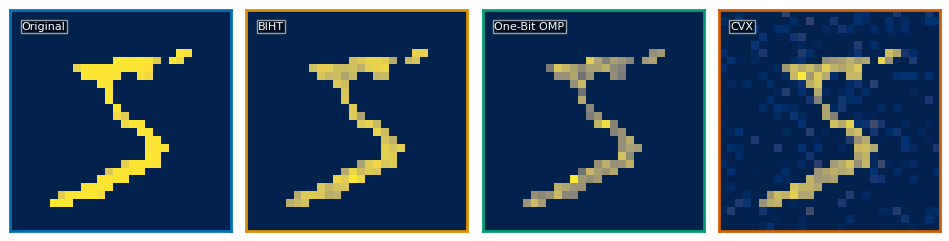

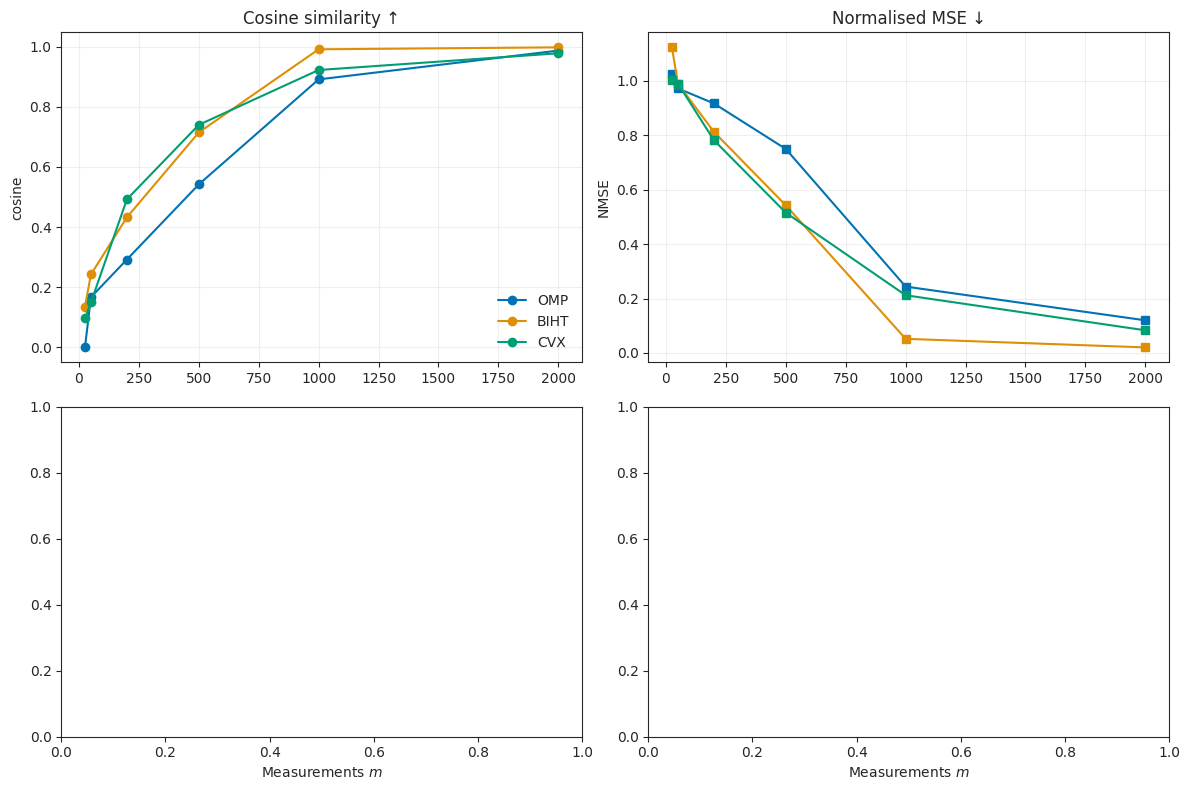

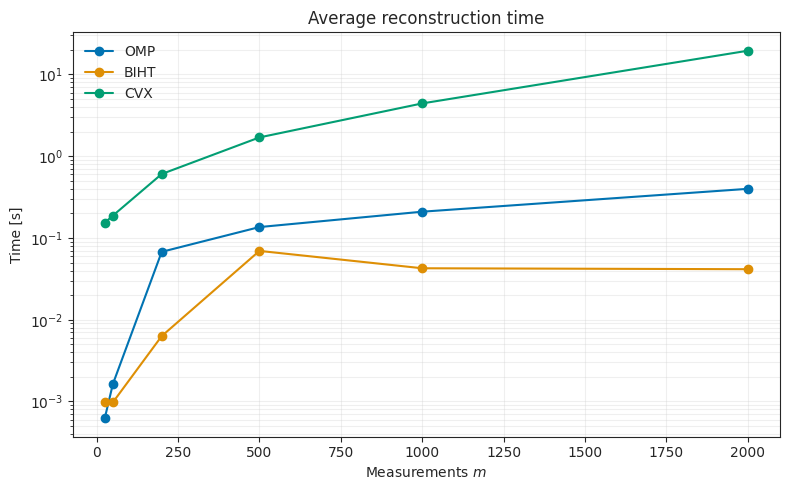

In [25]:
# Example script block adapted to match the improved visual style

import matplotlib.pyplot as plt

# Set number of test images
num_img = 1
test_data = get_images(sparse_data, 0, num_img)

# Run all three algorithms
cosine_sim_omp, mses_omp, missed_coeffs_omp, misided_coeffs_omp, curr_data, estimate_omp, convergence_omp, time_omp = test_algo(
    "one_bit_omp", num_img, test_data, meas_matrix_dims, known_sparsity=True, threshold=0, max_iter=1000)

cosine_sim_biht, mses_biht, missed_coeffs_biht, misided_coeffs_biht, _, estimate_biht, convergence_biht, time_biht = test_algo(
    "biht", num_img, test_data, meas_matrix_dims, known_sparsity=True, threshold=0, max_iter=1000)

cosine_sim_cvx, mses_cvx, missed_coeffs_cvx, misided_coeffs_cvx, _, estimate_cvx, convergence_cvx, time_cvx = test_algo(
    "inbuilt_solver", num_img, test_data, meas_matrix_dims, max_iter=1000)

# Reconstructed image strip
plot_algos(
    [curr_data, estimate_biht, estimate_omp, estimate_cvx],
    ["Original", "BIHT", "One-Bit OMP", "CVX"]
)

# Metric plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_metrics("OMP", axs, meas_matrix_dims, cosine_sim_omp, mses_omp, colour_id=0)
plot_metrics("BIHT", axs, meas_matrix_dims, cosine_sim_biht, mses_biht, colour_id=1)
plot_metrics("CVX", axs, meas_matrix_dims, cosine_sim_cvx, mses_cvx,  colour_id=2)

# Add legend once
axs[0, 0].legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

# Time plot
fig, ax_time = plt.subplots(figsize=(8, 5))
plot_time("OMP", ax_time, meas_matrix_dims, time_omp, colour_id=0)
plot_time("BIHT", ax_time, meas_matrix_dims, time_biht, colour_id=1)
plot_time("CVX", ax_time, meas_matrix_dims, time_cvx, colour_id=2)
ax_time.legend(frameon=False)
plt.tight_layout()
plt.show()


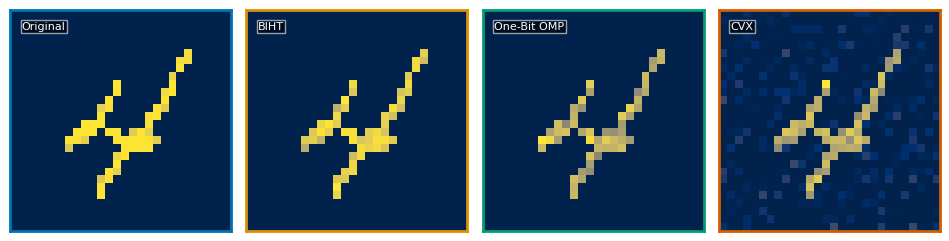

In [26]:
num_img = 10
test_data = get_images(sparse_data, 0, num_img)

# Run all three algorithms
cosine_sim_omp, mses_omp, missed_coeffs_omp, misided_coeffs_omp, curr_data, estimate_omp, convergence_omp, time_omp = test_algo(
    "one_bit_omp", num_img, test_data, meas_matrix_dims, known_sparsity=True, threshold=0, max_iter=1000)

cosine_sim_biht, mses_biht, missed_coeffs_biht, misided_coeffs_biht, _, estimate_biht, convergence_biht, time_biht = test_algo(
    "biht", num_img, test_data, meas_matrix_dims, known_sparsity=True, threshold=0, max_iter=1000)

cosine_sim_cvx, mses_cvx, missed_coeffs_cvx, misided_coeffs_cvx, _, estimate_cvx, convergence_cvx, time_cvx = test_algo(
    "inbuilt_solver", num_img, test_data, meas_matrix_dims, max_iter=1000)

# Reconstructed image strip
plot_algos(
    [curr_data, estimate_biht, estimate_omp, estimate_cvx],
    ["Original", "BIHT", "One-Bit OMP", "CVX"]
)


In [27]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim, matplotlib.pyplot as plt
from torchvision import datasets, transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class FCVAE(nn.Module):
    def __init__(self, latent_dim=40):
        super().__init__()
        self.z_dim = latent_dim
        self.enc = nn.Sequential(
            nn.Linear(784, 500), nn.ReLU(),
            nn.Linear(500, 500), nn.ReLU()
        )
        self.mu = nn.Linear(500, latent_dim)
        self.logvar = nn.Linear(500, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 500), nn.ReLU(),
            nn.Linear(500, 500), nn.ReLU(),
            nn.Linear(500, 784), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss(x_hat, x, mu, logvar):
    recon = torch.nn.functional.binary_cross_entropy(x_hat, x.view(-1,784), reduction='sum')
    kld = -0.5 * torch.sum(1+logvar - mu.pow(2) - logvar.exp())
    return recon + kld

def train_vae(epochs=10, batch=256, latent_dim=40, lr=1e-3):
    vae = FCVAE(latent_dim).to(DEVICE)
    opt = optim.Adam(vae.parameters(), lr=lr)
    loader = torch.utils.data.DataLoader(
        datasets.MNIST("./mnist", train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch, shuffle=True, drop_last=True)
    for ep in range(epochs):
        total = 0
        for img,_ in loader:
            img = img.to(DEVICE)
            x_hat, mu, logvar = vae(img)
            loss = vae_loss(x_hat, img, mu, logvar)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"Epoch {ep+1}/{epochs} ELBO {total/len(loader.dataset):.3f}")
    vae.eval()
    return vae

def make_A(m, n=784):
    A = np.random.randn(m, n).astype(np.float32)
    A /= np.linalg.norm(A, axis=0, keepdims=True)+1e-8
    return torch.from_numpy(A)

def onebit_measure(A, x):
    A = A.to(x.device)
    y = torch.sign(A @ x.view(-1))        # <-- no scaling
    y[y == 0] = 1
    return y

def latent_recon(A, y, vae, steps=1000, lr=1e-3, r=3.0):
    z  = torch.randn(1, vae.z_dim, device=DEVICE, requires_grad=True)
    A, y = A.to(DEVICE), y.to(DEVICE)
    opt  = optim.Adam([z], lr=lr)
    c    = np.sqrt(2/np.pi) / A.shape[0]  # correct constant
    for _ in range(steps):
        x_hat = vae.decode(z)
        x_hat = x_hat / x_hat.norm()         # unit length
             # already in [0,1]
        lam  = 30                          # tune between 1 and 50
        loss = x_hat.pow(2).sum() - lam*c * (y * (A @ x_hat.t()).squeeze()).sum()

        #loss   = x_hat.pow(2).sum() - c * (y * (A @ x_hat.t()).squeeze()).sum()
        opt.zero_grad(); loss.backward(); opt.step()
        with torch.no_grad():
            if z.norm() > r: z.mul_(r / z.norm())
    return x_hat.detach().cpu().view(28, 28)


In [28]:
# Train quick VAE
vae = train_vae(epochs=30)


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


Epoch 1/30 ELBO 200.864
Epoch 2/30 ELBO 147.439
Epoch 3/30 ELBO 128.759
Epoch 4/30 ELBO 120.445
Epoch 5/30 ELBO 115.912
Epoch 6/30 ELBO 112.983
Epoch 7/30 ELBO 110.434
Epoch 8/30 ELBO 108.668
Epoch 9/30 ELBO 107.424
Epoch 10/30 ELBO 106.345
Epoch 11/30 ELBO 105.496
Epoch 12/30 ELBO 104.689
Epoch 13/30 ELBO 104.130
Epoch 14/30 ELBO 103.587
Epoch 15/30 ELBO 103.049
Epoch 16/30 ELBO 102.672
Epoch 17/30 ELBO 102.310
Epoch 18/30 ELBO 101.856
Epoch 19/30 ELBO 101.536
Epoch 20/30 ELBO 101.301
Epoch 21/30 ELBO 100.940
Epoch 22/30 ELBO 100.714
Epoch 23/30 ELBO 100.449
Epoch 24/30 ELBO 100.220
Epoch 25/30 ELBO 99.991
Epoch 26/30 ELBO 99.822
Epoch 27/30 ELBO 99.589
Epoch 28/30 ELBO 99.395
Epoch 29/30 ELBO 99.186
Epoch 30/30 ELBO 99.018


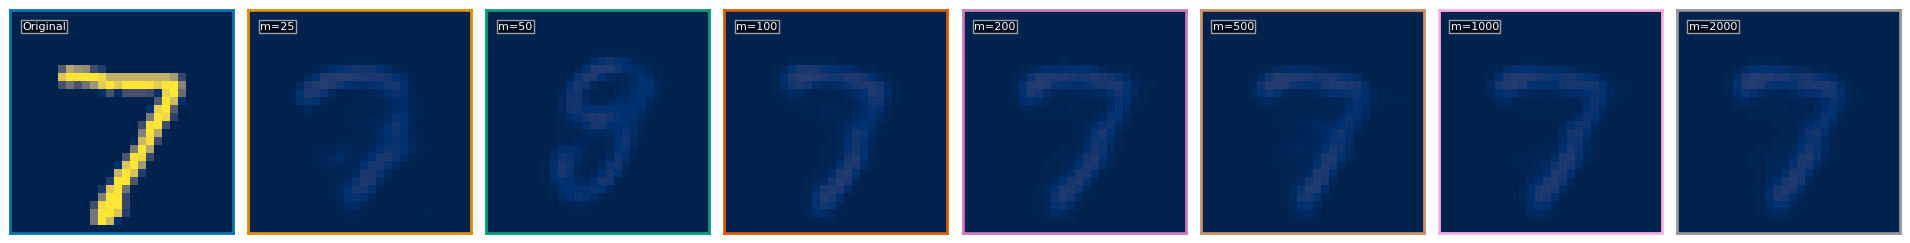

In [29]:
# Re-import necessary modules after environment reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style and color palette
sns.set_style("ticks")
PALETTE = sns.color_palette("colorblind", 8)
test_dataset = datasets.MNIST("./mnist", train=False, download=True, transform=transforms.ToTensor())
test_img = test_dataset[0][0].to(DEVICE)

ms = [25,50,100,200,500, 1000, 2000]
recons = []
for m in ms:
    A = make_A(m)
    y = onebit_measure(A, test_img)
    rec = latent_recon(A,y,vae, steps=3000)
    recons.append(rec)

# Function to calculate NMSE and cosine similarity
def nmse_and_cosine(truth, recon):
    x = truth.flatten()
    x_hat = recon.flatten()
    nmse_val = np.linalg.norm(x - x_hat)**2 / np.linalg.norm(x)**2
    cosine_val = np.dot(x, x_hat) / (np.linalg.norm(x) * np.linalg.norm(x_hat))
    return nmse_val, cosine_val

# Calculate NMSE and cosine similarity for each reconstruction
nmse_vals = []
cosine_vals = []

truth = test_img.cpu().numpy().squeeze()
for rec in recons:
    rec_np = rec.detach().cpu().numpy().squeeze()
    nmse, cos = nmse_and_cosine(truth, rec_np)
    nmse_vals.append(nmse)
    cosine_vals.append(cos)

nmse_vals, cosine_vals

# Redefine the visualization function for VAE reconstructions
def plot_vae_reconstructions(test_img, recons, ms, cm="cividis"):
    titles = ["Original"] + [f"m={m}" for m in ms]
    imgs = [test_img.cpu().numpy().squeeze()] + [r.detach().cpu().numpy().squeeze() for r in recons]

    n = len(imgs)
    plt.figure(figsize=(2.4 * n, 2.6))
    for i, (im, ttl) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(im.reshape(28, 28), cmap=cm, vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor(PALETTE[i % len(PALETTE)])
        ax.text(1, 2, ttl, color="w", fontsize=8,
                bbox=dict(fc="black", alpha=0.6, pad=1))
    plt.tight_layout()
    plt.show()
plot_vae_reconstructions(test_img, recons, ms)


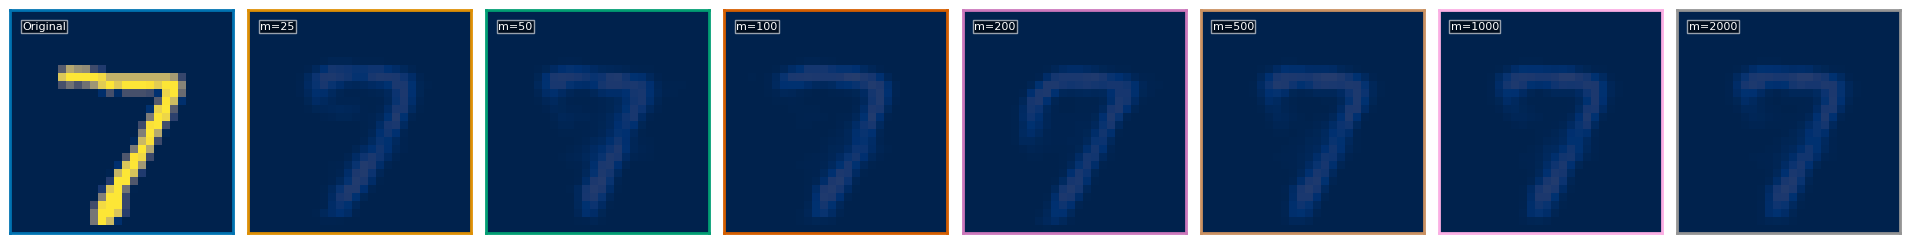

In [ ]:
# Modified version of the VAE reconstruction plot function
def plot_vae_reconstructions_yellow(test_img, recons, ms):
    titles = ["Original"] + [f"m={m}" for m in ms]
    imgs = [test_img.cpu().numpy().squeeze()] + [r.detach().cpu().numpy().squeeze() for r in recons]

    n = len(imgs)
    plt.figure(figsize=(2.4 * n, 2.6))
    for i, (im, ttl) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(im.reshape(28, 28), cmap="cividis", vmin=0, vmax=1)  # keep all in yellow-blue style
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor(PALETTE[i % len(PALETTE)])
        ax.text(1, 2, ttl, color="w", fontsize=8,
                bbox=dict(fc="black", alpha=0.6, pad=1))
    plt.tight_layout()
    plt.show()

PALETTE = sns.color_palette("colorblind", 8)
test_dataset = datasets.MNIST("./mnist", train=False, download=True, transform=transforms.ToTensor())
test_img = test_dataset[0][0].to(DEVICE)

ms = [25,50,100,200,500, 1000, 2000]
recons = []
for m in ms:
    A = make_A(m)
    y = onebit_measure(A, test_img)
    rec = latent_recon(A,y,vae, steps=3000)
    recons.append(rec)

plot_vae_reconstructions_yellow(test_img, recons, ms)
